<a href="https://colab.research.google.com/github/TungTNguyen/Image-Processing-Coding-Exam/blob/main/Image_Processing_Coding_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task: Determine the vanishing point of the given highway image.

In this assignment, we will implement a **vanishing point detection** application using Sobel edge detector and Hough transform.

## INPUT:

*   **test image**: the given test image (attached: '`Road_Image.jpg`' file),

*           **Sobel threshold**: threshold for Sobel edge detector (typically $50-100$). I find $70$ to be
        the best number


*           **Hough threshold**: threshold for Hough transform (typically about $200$). I choose $230$ by
        manual tuning.







**Summary**. The algorithm can broken down into the following steps:


1.   Convert the input image to a gray scale image.
2.   Implement the Sobel filter and detect edges in the binarized image using the Sobel filter with the Sobel threshold
2. **Accumulation step**:
Then find lines using the Hough transform based on the $\theta$-s and $\rho$-s from the input image. Keep only the lines that have an accumulator/accumulation count greater than a Hough transform threshold of about $200$. I choose $230$ by manual tuning.
3. **Search step:**
Then find all the intersections of every pair of the above lines whose angle ($\theta$-s) difference is greater than $30$ degrees.
1.   Then determine one vanishing point of the road by selecting an average $(x,y)$ positions of the above intersections.





In [ ]:
# Setup
from dataclasses import dataclass

# only these 2 libraries are necessary for a working and efficient implemetation of this task.
import numpy as np
import cv2

# this function is for displaying purpose on this Colab platform only:
from google.colab.patches import cv2_imshow


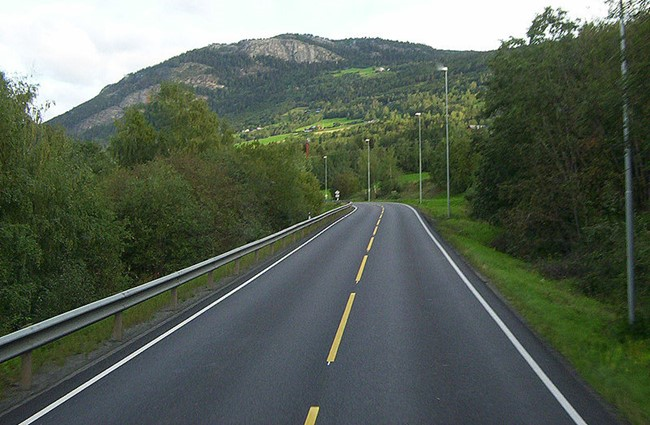

In [ ]:
"""Load the image.
First, upload the image onto here: in the left pane, click the folder icon, and then the upload icon to upload the file onto the memory of the system. """
test_image = cv2.imread('Road_Image.jpg')
cv2_imshow(test_image)

## 1 Gray scale conversion
Convert the input image to a gray scale image.

In [ ]:
def gray_scale(image):
    """Convert the input image to a gray scale image.

    image  - a numpy array of shape (rows, columns, 3).
    output - a numpy array of shape (rows, columns) and dtype same as
             image, containing a weighted sum of image's 3 channels.
    """
    red = image[:, :, 2]
    green = image[:, :, 1]
    blue = image[:, :, 0]
    # [1]
    output = (0.7152 * green + 0.2126 * red + 0.0722 * blue).astype(image.dtype)

    return output



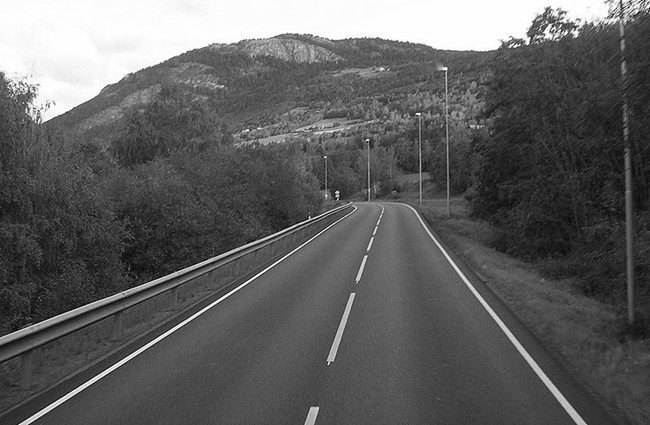

In [ ]:
gray_image = gray_scale(test_image)
cv2_imshow(gray_image)

## 2 Sobel Edge detection
Implement the Sobel filter and detect edges in the binarized image using the Sobel filter with the Sobel threshold

In [ ]:
def transform_xy_mag(dx, dy):
    """Transform from xy gradients to edge intensities.

    Input:

    dx, dy - the gradient images generated by applying sobel filters to an
    image. They both have shape (rows, cols) and dtype float.

    Output:

    mag - a numpy array of shape (rows, cols) and dtype float.

    Each location mag[i,j] should contain the magnitude of the gradient, which
    is sqrt(dx[i,j]^2 + dy[i,j]^2)

    """

    mag = None

    mag = np.zeros(dx.shape, float)
    mag = np.sqrt(np.square(dx) + np.square(dy))

    return mag


def conv_vectorized(image, kernel):
    """An opimized implementation of convolution filter using array processing.

    This function uses element-wise multiplication and np.sum()
    to efficiently compute weighted sum of neighborhood at each
    pixel.

    INPUT:
        image: numpy array of shape (Hi, Wi).
        kernel: numpy array of shape (Hk, Wk).

    OUTPUT:
        out: numpy array of shape (Hi, Wi).
    """
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    out = np.zeros((Hi, Wi))

    # For this project assignment, I will use edge values to pad the images.
    # Zero padding will make derivatives at the image boundary very big,
    # whereas I want to ignore the edges at the boundary.
    pad_width0 = Hk // 2
    pad_width1 = Wk // 2
    pad_width = ((pad_width0, pad_width0), (pad_width1, pad_width1))
    padded = np.pad(image, pad_width, mode="edge")

    # flip the kernel to avoid doing cross-correlation instead:
    kernel = kernel[::-1, ::-1]

    # Creating indices of the image patch:
    H_padded, W_padded = padded.shape
    h0 = np.repeat(np.arange(H_padded - Hk + 1), W_padded - Wk + 1).reshape(-1, 1)
    h1 = np.arange(Hk).reshape(1, Hk)
    h_padded = np.repeat(h0 + h1, Wk, axis=1)

    w0 = np.tile(np.arange(Wk), Hk).reshape(1, -1)
    w1 = np.arange(W_padded - Wk + 1).reshape(-1, 1)
    w_padded = np.tile(w0 + w1, [H_padded - Hk + 1, 1])

    y = padded[h_padded, w_padded].dot(kernel.reshape(-1, 1))
    out = y.reshape(H_padded - Hk + 1, W_padded - Wk + 1)

    return out


def make_gaussian_1d(k, std):
    """Create a gaussian kernel in one-dimension.

    Input:

    k - the radius of the kernel.

    std - the standard deviation of the kernel.

    Output:

    output - a numpy array of shape (2k+1, 1) and dtype float.

    gaussian_1d is a gaussian filter of length 2k+1 in one dimension,

    Once all the points are filled, the kernel should be scaled so that the sum
    of all cells is equal to one."""
    kernel = None
    gaussian_1D = np.zeros((2 * k + 1, 1), float)
    for n in range(2 * k + 1):
        gaussian_1D[n] = np.exp(-1 / 2 * ((n - k) / std) ** 2)

    kernel = gaussian_1D
    kernel = kernel / np.sum(kernel)
    return kernel


def optimized_gaussian_filter(image):
    truncate = 4.0
    # uses a gaussian filter with sigma = 2
    sigma = 2
    radius = round(truncate * sigma)

    gaussian_filter_x = make_gaussian_1d(k=radius, std=sigma)
    gaussian_filter_y = make_gaussian_1d(k=radius, std=sigma)
    out_image = conv_vectorized(image, gaussian_filter_x).astype(float)

    out_image = conv_vectorized(out_image, gaussian_filter_y.T).astype(float)
    return out_image


def optimized_sobel_filter(image):

    dx = conv_vectorized(image, np.array([[1, 2, 1]]).T)
    dx = conv_vectorized(dx, np.array([[1, 0, -1]]))

    dy = conv_vectorized(image, np.array([[1, 0, -1]]).T)
    dy = conv_vectorized(dy, np.array([[1, 2, 1]]))
    return dx, dy


def sobel_edge_detector(image, threshold=100):
    """detect edges in the binarized image using the above Sobel filter with the Sobel threshold:

    This function finds all edges in the given image.

    This implementation is based purely on numpy. It works without any dependency, and is
    optimized for speed.
    """

    # Convert image to gray
    gray_image = gray_scale(image) if len(image.shape) > 2 else image

    # blur so the gradient operation is less noisy.
    gray_image = optimized_gaussian_filter(gray_image).astype(float)

    dx, dy = optimized_sobel_filter(gray_image)

    # Convert to magnitude images
    mag = transform_xy_mag(dx, dy)

    # threshold the magnitude to the {0, 255} values, i.e. make the image binary [2].
    mag[mag < threshold] = 0
    mag[mag >= threshold] = 255

    return mag.astype(np.uint8)


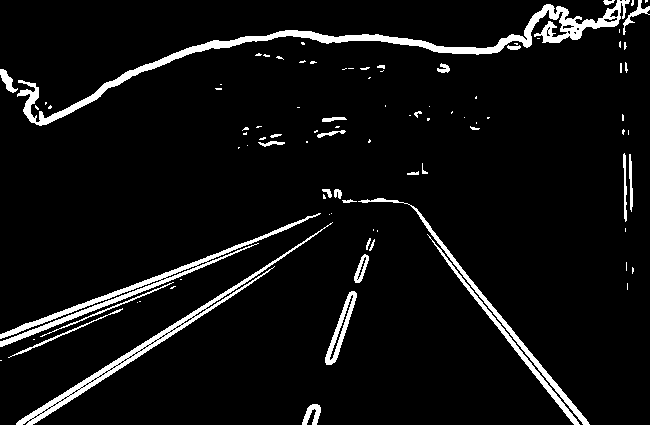

In [ ]:
edges = sobel_edge_detector(gray_image, threshold=70)
cv2_imshow(edges)


## 3 Fitting lines using Hough transform
**Accumulation step**:
Then find lines using the above Hough transform based on the $\theta$-s and $\rho$-s from the input image.

Keep only the lines that have an accumulator/accumulation count greater than a Hough transform threshold of about `200`. I choose `230` by manual tuning.


In [ ]:
def hf_vectorized(xs,ys, cos_t, sin_t, num_thetas, diag_len, accumulator):
    # compute the rhos for the given point for each theta
    current_rho = xs.reshape(-1,1) * cos_t.reshape(1,-1) + ys.reshape(-1,1) * sin_t.reshape(1,
                                                                                            -1)
    # for each rho, compute the closest rho among the rho_values below it
    # the index corresponding to that rho is the one we will increase
    rho_pos = (current_rho + diag_len).astype(int).reshape(-1)

    np.add.at(accumulator, (rho_pos, np.tile(range(num_thetas), len(xs))), 1)

def hough_transform(img):
    """ Hough transform algorithm:
    Transform points in the input image into Hough space.

    Use the parameterization:
        rho = x * cos(theta) + y * sin(theta)
    to transform a point (x,y) to a sine-like function in Hough space.

    INPUT:
        img: binary image of shape (H, W).

    OUTPUT:
        accumulator: numpy array of shape (m, n).
        rhos: numpy array of shape (m, ).
        thetas: numpy array of shape (n, ).
    """
    # Set rho and theta ranges
    W, H = img.shape
    diag_len = int(np.ceil(np.sqrt(W * W + H * H)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2 + 1)
    thetas = np.deg2rad(np.arange(-90.0, 90.0))
    # Cache some reusable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)
    # Initialize accumulator in the Hough space
    accumulator = np.zeros((2 * diag_len + 1, num_thetas), dtype=np.uint64)
    ys, xs = np.nonzero(img)
    # Transform each point (x, y) in image
    # Find rho corresponding to values in thetas
    # and increment the accumulator in the corresponding coordiate.
    # for i in range(num_thetas):
    #     rhos_i = (xs*cos_t[i] + ys*sin_t[i]+ diag_len).astype(int)#[j]
    #     np.add.at(accumulator, (rhos_i#j
    #                             ,i), 1)

    hf_vectorized(xs,ys, cos_t, sin_t, num_thetas, diag_len, accumulator)

    return accumulator, rhos, thetas

@dataclass
class Line:
    """Class for keeping track of a line."""

    xs: list[int]
    ys: list[int]
    a: float
    b: float
    theta: float


# I choose 230 by manual tuning.
def hough_lines(edges, image, threshold=230):
    """find lines using the above Hough transform based on the Thetas and Rhos from the input
    image.

    Keep only the lines that have an accumulator/accumulation count greater than a Hough
    transform threshold of about 200.
    """
    # Perform Hough transform on the edges
    acc, rhos, thetas = hough_transform(edges)

    # Easiest peak finding based on max votes
    indices = np.nonzero(acc > threshold)

    # Coordinates for right lane
    right_lines = []
    xs_right = []
    ys_right = []
    thetas_right = []
    as_right = []
    bs_right = []

    # Coordinates for left lane
    left_lines = []
    xs_left = []
    ys_left = []
    thetas_left = []
    as_left = []
    bs_left = []

    for i in range(len(indices[0])):
        if np.max(acc) <= threshold:
            break
        idx = np.argmax(acc)

        r_idx = idx // acc.shape[1]
        t_idx = idx % acc.shape[1]
        acc[r_idx, t_idx] = 0  # Zero out the max value in accumulator

        rho = rhos[r_idx]
        theta = thetas[t_idx]

        # Transform a point in Hough space to a line in xy-space.
        if np.sin(theta) != 0:
            a = -(np.cos(theta) / np.sin(theta))  # slope of the line
        else:
            continue
            a = 0
        if np.sin(theta) != 0:
            b = rho / np.sin(theta)  # y-intersect of the line
        else:
            continue
            b = 0

        """An addition to the threshold: Break if both right and left lanes are detected. I
        use both to improve efficiency and also accuracy."""
        if xs_right and xs_left:
            break
        line = Line([], [], a=a, b=b, theta=theta)
        # Left lane
        if a < 0:
            thetas_left.append(theta)
            as_left.append(a)
            bs_left.append(b)
            left_lines.append(line)
            if xs_left:
                continue
            xs = xs_left
            ys = ys_left
        # Right Lane
        else:
            thetas_right.append(theta)
            as_right.append(a)
            bs_right.append(b)
            right_lines.append(line)
            if xs_right:
                continue
            xs = xs_right
            ys = ys_right
        for x in range(image.shape[1]):
            y = a * x + b
            if y > image.shape[0] * 0.6 and y < image.shape[0]:
                xs.append(x)
                ys.append(int(round(y)))
                line.xs.append(x)
                line.ys.append(int(round(y)))
    return left_lines, right_lines


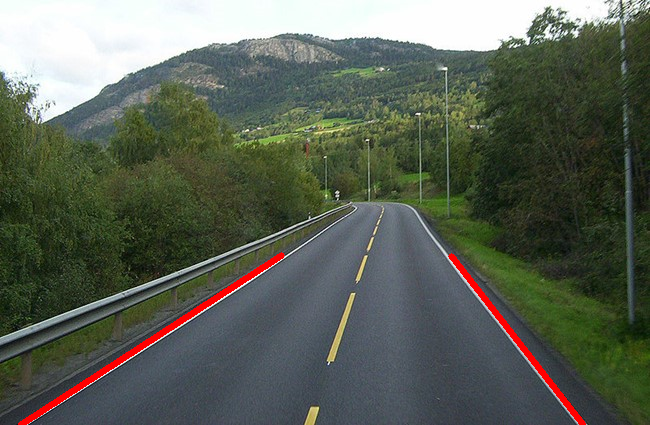

In [ ]:
    test_image_copy = test_image.copy()

    left_lines, right_lines = hough_lines(edges, test_image, threshold=200)
    thetas_left = [line.theta for line in left_lines]
    as_left = [line.a for line in left_lines]
    bs_left = [line.b for line in left_lines]
    thetas_right = [line.theta for line in right_lines]
    as_right = [line.a for line in right_lines]
    bs_right = [line.b for line in right_lines]
    # displaying the test image with the Hough lines superimposed.
    xs_left = np.concatenate([[x for x in line.xs] for line in left_lines])
    ys_left = np.concatenate([[y for y in line.ys] for line in left_lines])
    xs_right = np.concatenate([[x for x in line.xs] for line in right_lines])
    ys_right = np.concatenate([[y for y in line.ys] for line in right_lines])

    for (x, y) in zip(xs_left, ys_left):
        image = cv2.circle(
            test_image_copy, (int(x), int(y)), radius=0, color=(0, 0, 255), thickness=5
        )
    for (x, y) in zip(xs_right, ys_right):
        image = cv2.circle(
            test_image_copy, (int(x), int(y)), radius=0, color=(0, 0, 255), thickness=5
        )

    cv2_imshow(
               test_image_copy)


## 4 Find all the intersections
**Search step:**
Then find all the intersections of every pair of the above lines whose angle ($\theta$-s) difference is greater than $30^{\circ}$ degrees.

In [ ]:
def lines_intersect(a, b, a2, b2):
    if a == a2:
        print("These lines are parallel.")
        return None
    # Set both lines equal to find the intersection point in the x direction
    x = (b2 - b) / (a - a2)
    # Now solve for y -- use either line, because they are equal here
    y = a * x + b
    return np.array([x, y])
def find_intersections(
    thetas_left,
    as_left,
    bs_left,
    thetas_right,
    as_right,
    bs_right,
    intersection_degree_threshold: float = 30,
) -> list[...]:
    """find all the intersections of every pair of the above lines whose angle (Thetas)
    difference is greater than 30 degrees.
    """
    intersections = []
    for theta_left, a_left, b_left in zip(thetas_left, as_left, bs_left):
        for theta_right, a_right, b_right in zip(thetas_right, as_right, bs_right):
            if (
                np.abs(np.rad2deg(theta_left) - np.rad2deg(theta_right))
                > intersection_degree_threshold
            ):
                intersections.append(lines_intersect(a_left, b_left, a_right, b_right))
    return intersections


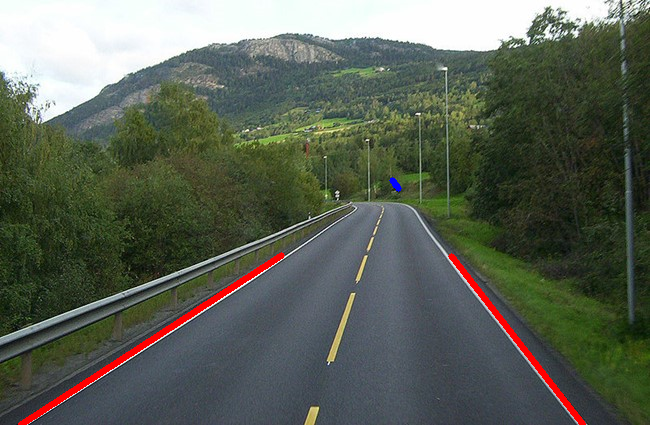

In [ ]:
intersections = find_intersections(
        thetas_left, as_left, bs_left, thetas_right, as_right, bs_right)
xs_intersections = [intersection[0] for intersection in intersections]
ys_intersections = [intersection[1] for intersection in intersections]
# display/add the intersections onto the test image.
for x, y in zip(xs_intersections, ys_intersections):
    image = cv2.circle(test_image_copy, (round(x), round(y)), radius=0, color=(255, 0, 0), thickness=5)
cv2_imshow(
            test_image_copy)

## 5 Determine one vanishing point
Then determine one vanishing point of the road by selecting an average $(x,y)$ positions of the above intersections.

In [ ]:
vanishing_point = np.mean(intersections, axis=0)
print("The vanishing point of the given highway image: ", vanishing_point)

The vanishing point of the given highway image:  [394.65151172 183.52558945]


## OUTPUT:
Test image with the Hough lines highlighted by red lines, and mark the vanishing point by Blue circle at $(x,y)$

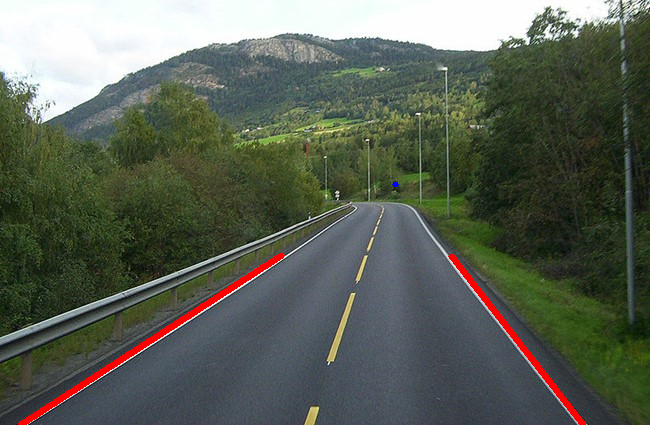

In [ ]:
test_image_copy2 = test_image.copy()
for (x, y) in zip(xs_left, ys_left):
    image = cv2.circle(
            test_image_copy2, (int(x), int(y)), radius=0, color=(0, 0, 255), thickness=5
        )
for (x, y) in zip(xs_right, ys_right):
    image = cv2.circle(
            test_image_copy2, (int(x), int(y)), radius=0, color=(0, 0, 255), thickness=5
        )

image = cv2.circle(
        test_image_copy2,
        (round(vanishing_point[0]), round(vanishing_point[1])),
        radius=0,
        color=(255, 0, 0),
        thickness=5,
    )

cv2_imshow(
            test_image_copy2)


# Sources:
[1] https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale

[2] https://perso.crans.org/besson/cs101/projects/CS101_project_edge_detection_description.pdf